In [101]:
from stylelib import *
from process_helper import *

In [102]:
path = "/Users/scarlet/Downloads/Github/Sundial-Private/outputs/"
paper_path = "revision/"
storage = "redis"
selectby = "median"
unit = "ms"

## 0. Select Color Scheme

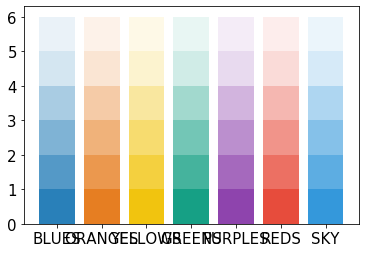

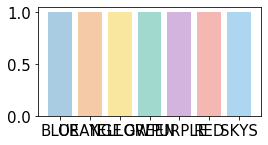

<Figure size 288x144 with 0 Axes>

In [103]:
_, grad_colors = display_colors()
_, bar_colors = select_color_idx(2)
_, line_colors = select_color_idx(4)

In [104]:
C_1PC

'ORANGE'

In [105]:
C_2PC

'BLUE'

In [106]:
plt.rcParams.update({'font.size': 18})
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5

## Process Data

In [107]:
# process data of cornus opt
df_opt = pd.read_csv(path+"test_cornus_opt.csv")
df_opt["COMMIT_ALG"] = df_opt["COMMIT_VAR"]
df_opt = apply_mask(df_opt, [("LOG_DELAY", 0)])

In [108]:
# process data of mdcc classic / paxos commit
df_mdcc = pd.read_csv(path+"test_mdcc.csv")
df_mdcc["COMMIT_ALG"] = df_mdcc["COMMIT_VAR"]
df_mdcc = apply_mask(df_mdcc, [("LOG_DELAY", 0)])

In [109]:
# df = pd.read_csv(path+"test_num_replica_rerun.csv")
df = pd.read_csv(path+"num_replicas.csv")
df["COMMIT_ALG"] = ["{}-{}".format(alg, colocate) for alg, colocate in zip(df["COMMIT_ALG"], df["COMMIT_VAR"])]
df = apply_mask(df, [("LOG_DELAY", 0)])

In [110]:
print(df.shape)
print(df_mdcc.shape)
print(df_opt.shape)

(40, 190)
(20, 190)
(10, 189)


In [111]:
df = pd.concat([df, df_opt, df_mdcc], axis=0, sort=False)
df.shape

(70, 191)

In [112]:
def process_throughput(x, df):
    if not isinstance(x, str):
        agg_throughput = df.groupby(['COMMIT_ALG', 'i'] + x, as_index=False)['Throughput'].sum()
    else:
        # sum up throughput for each trial
        agg_throughput = df.groupby(['COMMIT_ALG', 'i', x], as_index=False)['Throughput'].sum()
    return agg_throughput

def process_latency(x, df, latency_type="dist_latency", select=None):
    # require agg_throughput to indicate trial id as trials are selected by max throughput
    # process the latency
    latency = []

    if select is not None:
        if not isinstance(x, str):
            select = select.set_index(["COMMIT_ALG"] + x)
        else:
            select = select.set_index(["COMMIT_ALG", x])
            
    if isinstance(x, str):
        for (alg, i, v), group in df.groupby(['COMMIT_ALG', 'i', x]):
            if select is not None:
                if select.loc[(alg, v), "i"] != i:
                    continue
            # calculate weighted sum for each column/attribute
            weight = WEIGHT[latency_type]
            record = {"COMMIT_ALG": alg, "i": i, x: v}
            for y in TYPE[latency_type]:
                if group[weight].sum() == 0:
                    print("[WARNING]: zero weight %s" % weight)
                    agg = np.nan
                    break
                agg = (group[y] * group[weight]).sum() / group[weight].sum()
                record[PREFIX+y] = agg
            if np.isnan(agg):
                continue
            latency.append(record)
    else:
        for tags, group in df.groupby(['COMMIT_ALG', 'i'] + x):
            alg = tags[0]
            i = tags[1]
            v = tags[2:]
            if select is not None:
                if select.loc[tuple([alg]+list(v)), "i"] != i:
                    continue
            # calculate weighted sum for each column/attribute
            weight = WEIGHT[latency_type]
            record = {"COMMIT_ALG": alg, "i": i}
            for kid, key in enumerate(x):
                record[key] = v[kid]
            for y in TYPE[latency_type]:
                if group[weight].sum() == 0:
                    print("[WARNING]: zero weight %s" % weight)
                    agg = np.nan
                    break
                agg = (group[y] * group[weight]).sum() / group[weight].sum()
                record[PREFIX+y] = agg
            if np.isnan(agg):
                continue
            latency.append(record)
    latency = pd.DataFrame(data=latency)
    return latency


def aggregate(x, df, latency_type="dist_latency", agg="latency", how="minmax"):
    # drop invalid data
    data = df.dropna(subset=y_agg_latency+["Throughput"], axis=0)
    data = data[data['Throughput'] != 0]
    throughput = process_throughput(x, data)
    latency = process_latency(x, data, latency_type=latency_type)
    if isinstance(x, str):
        select_cols = ['COMMIT_ALG', 'i', x]
        select_cols_noid = ['COMMIT_ALG', x]
    else:
        select_cols = ['COMMIT_ALG', 'i'] + x
        select_cols_noid = ['COMMIT_ALG'] + x
        
    if agg != "throughput":
        if how == "minmax":
            idx_max = latency.groupby(select_cols_noid)[PREFIX+TYPE[latency_type][0]].idxmin().values
            print("selected trial with min {}".format(PREFIX+TYPE[latency_type][0]))
        elif how == "median":
            agg_col = PREFIX+TYPE[latency_type][0]
            idx_max = []
            for name, group in latency.groupby(select_cols_noid):
                n = int(group.shape[0] / 2) - 1
                idx_max.append(group.sort_values(agg_col).index.values[n])
            print("selected trial with median {}".format(PREFIX+TYPE[latency_type][0]))
        agg_latency = latency.loc[idx_max]
        agg_throughput = throughput.loc[select(throughput, agg_latency, select_cols)]
    else:
        # select the trials with highest throughput
        idx_max = agg_throughput.groupby(select_cols_noid)['Throughput'].idxmax().values
        agg_throughput = agg_throughput.loc[idx_max]
        print("selected trial with max throughput")
        agg_latency = latency.loc[select(latency, agg_throughput, select_cols)]
    return agg_throughput, agg_latency

In [113]:
exp = "num_replica_%s"%storage
x = "NUM_STORAGE_NODES"
selectby="minmax"
agg_throughput, agg_latency = aggregate(x, df, latency_type="dist_latency", agg="latency", how=selectby)
agg_single_latency = process_latency(x, df, latency_type="single_part_latency", select=agg_latency)
agg_multi_latency = process_latency(x, df, latency_type="multi_part_latency", select=agg_latency)

selected trial with min AGG_average_dist_latency
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARNING]: zero weight num_single_part_txn
[WARN

In [114]:
opt = ["COMMIT_ALG"]
df.groupby([x]+opt)["average_dist_latency"].median()

NUM_STORAGE_NODES  COMMIT_ALG       
0                  CORNUS_OPT           0.050569
                   MDCC_CLASSIC         0.050827
                   ONE_PC-COLOCATE      0.051487
                   ONE_PC-NO_VARIANT    0.049466
                   TWO_PC-COLOCATE      0.074839
                   TWO_PC-NO_VARIANT    0.077031
1                  CORNUS_OPT           0.079625
                   MDCC_CLASSIC         0.077514
                   ONE_PC-COLOCATE      0.082620
                   ONE_PC-NO_VARIANT    0.078184
                   TWO_PC-COLOCATE      0.121209
                   TWO_PC-NO_VARIANT    0.133817
2                  CORNUS_OPT           0.094619
                   MDCC_CLASSIC         0.078599
                   ONE_PC-COLOCATE      0.077731
                   ONE_PC-NO_VARIANT    0.078854
                   TWO_PC-COLOCATE      0.130340
                   TWO_PC-NO_VARIANT    0.135266
3                  CORNUS_OPT           0.080532
                   MDCC_CLASSIC 

In [1]:
1/(0.077373 / 0.085146)

1.1004614012640068

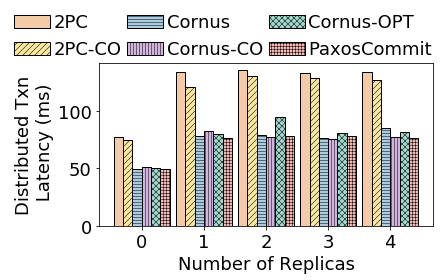

In [119]:
color_names = [C_1PC, "YELLOW", C_2PC, "PURPLE", "GREEN", "RED"]
color_patches = [bar_colors[c] for c in color_names]
color = [grad_colors[c+"S"] for c in color_names]
lcolor = [line_colors[C_1PC],line_colors[C_2PC]]
pattern = ALL_PATTERNS
scale = 1
if unit == "ms":
    scale = 1000
elif unit == "us":
    scale = 1000000
linestyle = ["-", "--"] # avg, tail

prefix="AGG_"
algcol = "COMMIT_ALG"
labels = ["2PC", "2PC-CO", "Cornus", "Cornus-CO", "Cornus-OPT", "PaxosCommit"]
# algs = ["TWO_PC-False", "TWO_PC-True", "ONE_PC-False", "ONE_PC-True", "CORNUS_OPT"]
algs = ["TWO_PC-NO_VARIANT", "TWO_PC-COLOCATE", "ONE_PC-NO_VARIANT", "ONE_PC-COLOCATE", "CORNUS_OPT", "MDCC_CLASSIC"]
width = 0.9 / len(algs)
offset = np.arange(-0.45+0.5*width, 0.5, width)

fig, ax = plt.subplots()
xvalues = [0, 1, 2, 3, 4]
for xid, xv in enumerate(xvalues):
    data = apply_mask(agg_latency, [(x, xv)])
    for idx, alg in enumerate(algs):
        plot_data = apply_mask(data, [(algcol, alg)])
        for yid, y in enumerate(["average_dist_latency"]):
            v = plot_data[PREFIX + y].values * scale
            p = ax.bar(xid + offset[idx], v, bottom=0, width=width, 
                       color=color[idx][2], hatch=pattern[idx], edgecolor='black')
ax.set_xticklabels([""] + xvalues)
ax.set_xlabel("Number of Replicas")
plt.legend(labels, loc="upper left", bbox_to_anchor=((-0.3,1.4)), ncol=3, frameon=False,
                     prop={'size': 18}, columnspacing=0.3, handletextpad=0.2)
ax.set_ylabel("Distributed Txn\n Latency (%s)"%unit)
fig.set_size_inches(6, 3)
plt.savefig(paper_path+exp+"({}_latency).pdf".format(selectby), bbox_inches="tight")